# Import and Config

In [1]:
from typing import Tuple
import pandas as pd
import numpy as np
import spacy
from spacy.tokens import Token, Doc
from sentence_transformers import SentenceTransformer
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import wget as wget
import zipfile

c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
sample_size = 1000
spacy_model = spacy.load("en_core_web_sm")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Load Dataset

## Download Dataset

In [4]:
wget.download("https://pilehvar.github.io/wic/package/WiC_dataset.zip")

'WiC_dataset (16).zip'

In [5]:
# Define the path to your zip file and the target directory for extraction
zip_file_path = 'WiC_dataset.zip'
extract_dir = 'WiC_dataset'

# Create the target directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file in read mode ('r')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(extract_dir)

print(f"Contents of '{zip_file_path}' extracted to '{extract_dir}'")

Contents of 'WiC_dataset.zip' extracted to 'WiC_dataset'


## Load Dataset

In [6]:
# Load training data
train_df = pd.read_csv("./WiC_dataset/train/train.data.txt", sep="\t", header=None)
train_df = train_df[:sample_size]
train_df.columns = ["lemma", "pos", "index1-index2", "sent_1", "sent_2"]

# Load ground truth labels
train_labels = pd.read_csv("./WiC_dataset/train/train.gold.txt", header=None)
train_labels = train_labels[:sample_size]
train_labels.columns = ["is_related"]
train_labels["is_related"] = train_labels["is_related"].apply(lambda x: 1 if x == "T" else 0)

# clean dataframe
train_df["pos"] = train_df["pos"].apply(lambda x: x.lower())
train_df["tok_idx_1"] = train_df["index1-index2"].apply(lambda x: int(x.split("-")[0]))
train_df["tok_idx_2"] = train_df["index1-index2"].apply(lambda x: int(x.split("-")[1]))
train_df.drop("index1-index2", axis=1, inplace=True)

train_df.head()

,lemma,pos,sent_1,sent_2,tok_idx_1,tok_idx_2
0,carry,v,You must carry your camping gear .,Sound carries well over water .,2,1
1,go,v,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,2,6
2,break,v,Break an alibi .,The wholesaler broke the container loads into ...,0,2
3,cup,n,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,8,4
4,academy,n,The Academy of Music .,The French Academy .,1,2


# Embed Dataset

In [7]:
def get_branch_tuple_embedding(
                branch: tuple|str
        ) -> tuple|np.ndarray:
        if isinstance(branch, tuple):
                return tuple([
                        get_branch_tuple_embedding(child)
                        for child in branch
                ])
        elif isinstance(branch, str):
                return embedding_model.encode(branch)

In [8]:
embedding_dict = dict()
for i in [1, 2]:
    embedding_dict.update({
        f"branch_tuple_embedding_{i}": list(),
        f"branch_text_{i}": list(),
        f"sent_{i}_embedding": list()
    })

for i, row in train_df.iterrows():
    
    for j in [1, 2]:
        doc = spacy_model(row[f"sent_{j}"])
        tok = doc[row[f"tok_idx_{j}"]]

        tok_lefts = [str(t.lemma_) for t in tok.lefts]
        tok_rights = [str(t.lemma_) for t in tok.rights if not t.is_punct]
        branch = [str(tok.lemma_)]
        if len(tok_lefts) > 0:
            branch.append(tuple(tok_lefts))
        if len(tok_rights) > 0:
            branch.append(tuple(tok_rights))
        branch = tuple(branch)

        # if the current token has a parent,
        #   add it to the branch
        if tok.has_head:
            branch = (str(tok.head.lemma_), tuple(branch))

        branch_tuple_embedding = get_branch_tuple_embedding(branch)

        # store in dataframe
        embedding_dict[f"branch_tuple_embedding_{j}"].append(branch_tuple_embedding)
        embedding_dict[f"branch_text_{j}"].append(branch)
        embedding_dict[f"sent_{j}_embedding"].append(embedding_model.encode(row[f"sent_{j}"]))

In [9]:
# Convert embedding dictionaries to dataframe
embedding_df = pd.DataFrame(embedding_dict)
train_df = pd.concat([train_df, embedding_df, train_labels], axis=1)
train_df.head()

,lemma,pos,sent_1,sent_2,tok_idx_1,tok_idx_2,branch_tuple_embedding_1,branch_text_1,sent_1_embedding,branch_tuple_embedding_2,branch_text_2,sent_2_embedding,is_related
0,carry,v,You must carry your camping gear .,Sound carries well over water .,2,1,"([-0.029717186, 0.032946438, -0.0110207, 0.025...","(carry, (carry, (you, must), (gear,)))","[0.015941845, 0.055019975, -0.011962686, 0.046...","([-0.029717186, 0.032946438, -0.0110207, 0.025...","(carry, (carry, (sound,), (over,)))","[0.013950539, -0.00032920958, 0.103703834, -0....",0
1,go,v,Messages must go through diplomatic channels .,Do you think the sofa will go through the door ?,2,6,"([-0.04356904, -0.011257142, -0.064884424, 0.0...","(go, (go, (message, must), (through,)))","[0.062830634, -0.034217775, 0.043997843, -0.02...","([-0.016079465, -0.029352862, -0.017893165, -0...","(think, (go, (sofa, will), (through,)))","[0.09026999, -0.022930702, -0.047347598, -0.00...",0
2,break,v,Break an alibi .,The wholesaler broke the container loads into ...,0,2,"([-0.059872787, -0.005924462, 0.073366605, 0.0...","(break, (break, (alibi,)))","[0.006467384, 0.078219905, -0.0016844621, -0.0...","([-0.059872787, -0.005924462, 0.073366605, 0.0...","(break, (break, (wholesaler,), (load, into)))","[0.0024547577, 0.04033635, 0.08594135, 0.02610...",0
3,cup,n,He wore a jock strap with a metal cup .,Bees filled the waxen cups with honey .,8,4,"([-0.0012284532, 0.06969771, -0.01881281, 0.03...","(with, (cup, (a, metal)))","[0.009509483, 0.12864761, -0.0009284174, 0.020...","([-0.030876772, 0.027268011, -0.03338937, 0.01...","(fill, (cup, (the, waxen)))","[0.02304507, 0.016278429, 0.0867929, 0.0199585...",1
4,academy,n,The Academy of Music .,The French Academy .,1,2,"([-0.05931168, -0.053230654, -0.06438178, 0.02...","(Academy, (Academy, (the,), (of,)))","[-0.025275927, -0.03941192, -0.034509167, 0.02...","([-0.05931168, -0.053230654, -0.06438178, 0.02...","(Academy, (Academy, (the, French)))","[-0.04209039, 0.0012604811, -0.030817553, -0.0...",0


# Dimensionality Reduction Analysis

We'll analyze the sentence embeddings using multiple dimensionality reduction techniques:
- **PCA (Principal Component Analysis)**: Linear method, preserves global structure
- **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: Non-linear, preserves local structure
- **Kernel PCA**: Non-linear extension of PCA using kernel trick
- **UMAP (Uniform Manifold Approximation and Projection)**: Non-linear, preserves both local and global structure

In [10]:
# Import dimensionality reduction libraries
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
import time

## Prepare Data for Analysis

We'll use the sentence embeddings from both sentences and analyze how well different dimensionality reduction techniques separate related vs unrelated word senses.

In [11]:
# Stack embeddings from both sentences
sent_1_embeddings = np.vstack(train_df['sent_1_embedding'].values)
sent_2_embeddings = np.vstack(train_df['sent_2_embedding'].values)

# Concatenate sentence pairs
X_combined = np.hstack([sent_1_embeddings, sent_2_embeddings])

# Get labels
y = train_df['is_related'].values

print(f"Combined embedding shape: {X_combined.shape}")
print(f"Number of related pairs: {sum(y == 1)}")
print(f"Number of unrelated pairs: {sum(y == 0)}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

Combined embedding shape: (1000, 768)
Number of related pairs: 400
Number of unrelated pairs: 600


## PCA (Principal Component Analysis)

PCA is a linear dimensionality reduction technique that finds orthogonal directions of maximum variance.

In [12]:
# Apply PCA
start_time = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_time = time.time() - start_time

print(f"PCA computation time: {pca_time:.2f} seconds")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.4f}")

PCA computation time: 0.01 seconds
Explained variance ratio: [0.02159908 0.01628046]
Total variance explained: 0.0379


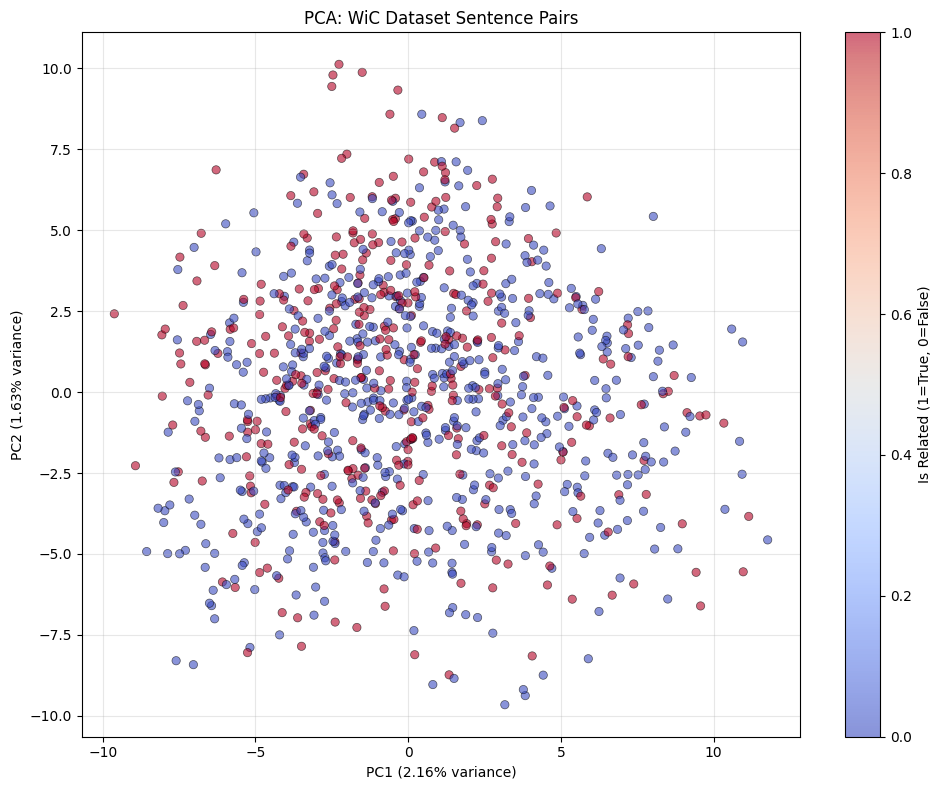

In [13]:
# Visualize PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Is Related (1=True, 0=False)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: WiC Dataset Sentence Pairs')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE is a non-linear technique that excels at preserving local structure and revealing clusters in high-dimensional data.

In [14]:
# Apply t-SNE with different perplexity values
start_time = time.time()
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    max_iter=1000,
    verbose=0
)
X_tsne = tsne.fit_transform(X_scaled)
tsne_time = time.time() - start_time

print(f"t-SNE computation time: {tsne_time:.2f} seconds")
print(f"KL divergence: {tsne.kl_divergence_:.4f}")

t-SNE computation time: 1.88 seconds
KL divergence: 1.9236


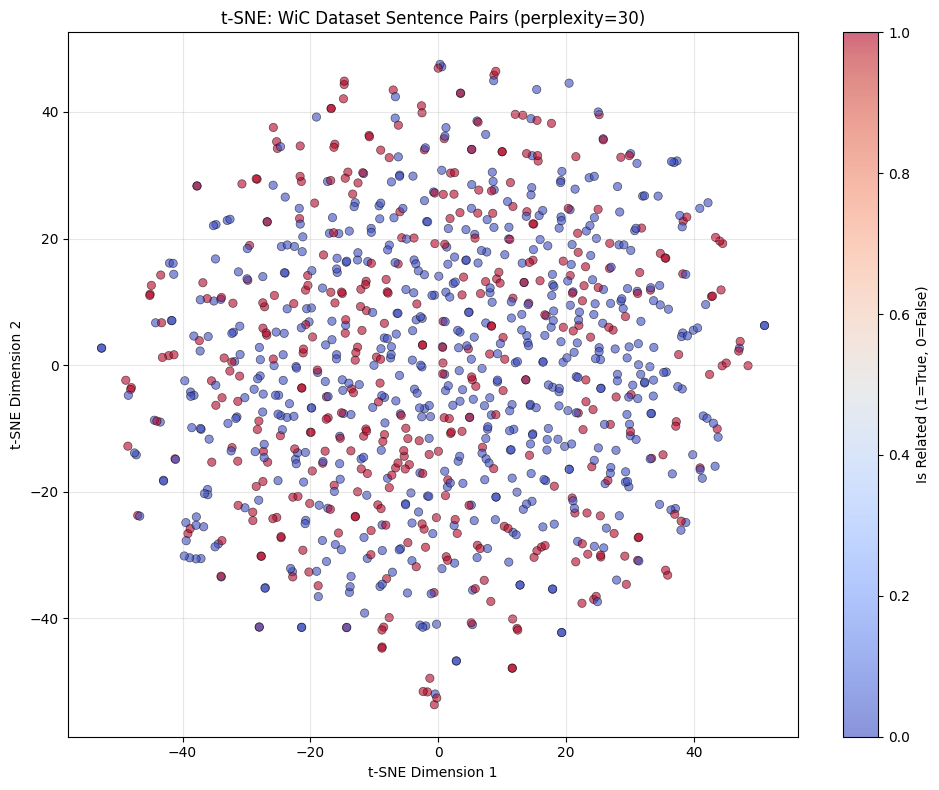

In [15]:
# Visualize t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Is Related (1=True, 0=False)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE: WiC Dataset Sentence Pairs (perplexity=30)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Kernel PCA

Kernel PCA uses the kernel trick to perform non-linear dimensionality reduction. We'll test with RBF kernel.

In [16]:
# Apply Kernel PCA with RBF kernel
start_time = time.time()
kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=None, random_state=42)
X_kpca_rbf = kpca_rbf.fit_transform(X_scaled)
kpca_rbf_time = time.time() - start_time

print(f"Kernel PCA (RBF) computation time: {kpca_rbf_time:.2f} seconds")

# Also try polynomial kernel for comparison
start_time = time.time()
kpca_poly = KernelPCA(n_components=2, kernel='poly', degree=3, random_state=42)
X_kpca_poly = kpca_poly.fit_transform(X_scaled)
kpca_poly_time = time.time() - start_time

print(f"Kernel PCA (Polynomial) computation time: {kpca_poly_time:.2f} seconds")

Kernel PCA (RBF) computation time: 0.05 seconds
Kernel PCA (Polynomial) computation time: 0.03 seconds


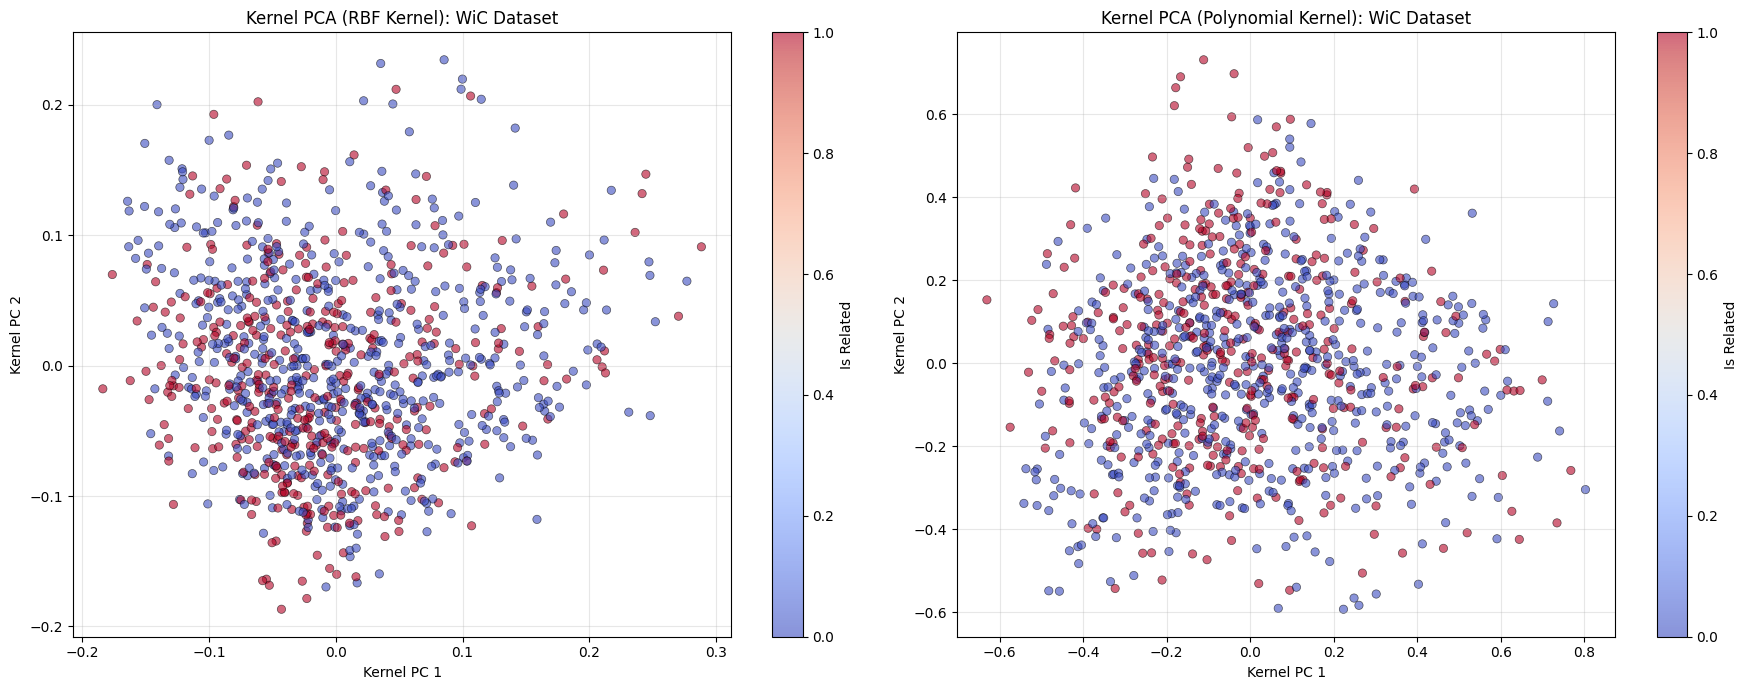

In [17]:
# Visualize Kernel PCA results
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# RBF Kernel
scatter1 = axes[0].scatter(X_kpca_rbf[:, 0], X_kpca_rbf[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel('Kernel PC 1')
axes[0].set_ylabel('Kernel PC 2')
axes[0].set_title('Kernel PCA (RBF Kernel): WiC Dataset')
axes[0].grid(True, alpha=0.3)
fig.colorbar(scatter1, ax=axes[0], label='Is Related')

# Polynomial Kernel
scatter2 = axes[1].scatter(X_kpca_poly[:, 0], X_kpca_poly[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel('Kernel PC 1')
axes[1].set_ylabel('Kernel PC 2')
axes[1].set_title('Kernel PCA (Polynomial Kernel): WiC Dataset')
axes[1].grid(True, alpha=0.3)
fig.colorbar(scatter2, ax=axes[1], label='Is Related')

plt.tight_layout()
plt.show()

## UMAP (Uniform Manifold Approximation and Projection)

UMAP is a modern technique that preserves both local and global structure better than t-SNE, and is generally faster.

In [18]:
# Apply UMAP
start_time = time.time()
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = umap_reducer.fit_transform(X_scaled)
umap_time = time.time() - start_time

print(f"UMAP computation time: {umap_time:.2f} seconds")

c:\Users\igeek\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP computation time: 10.58 seconds


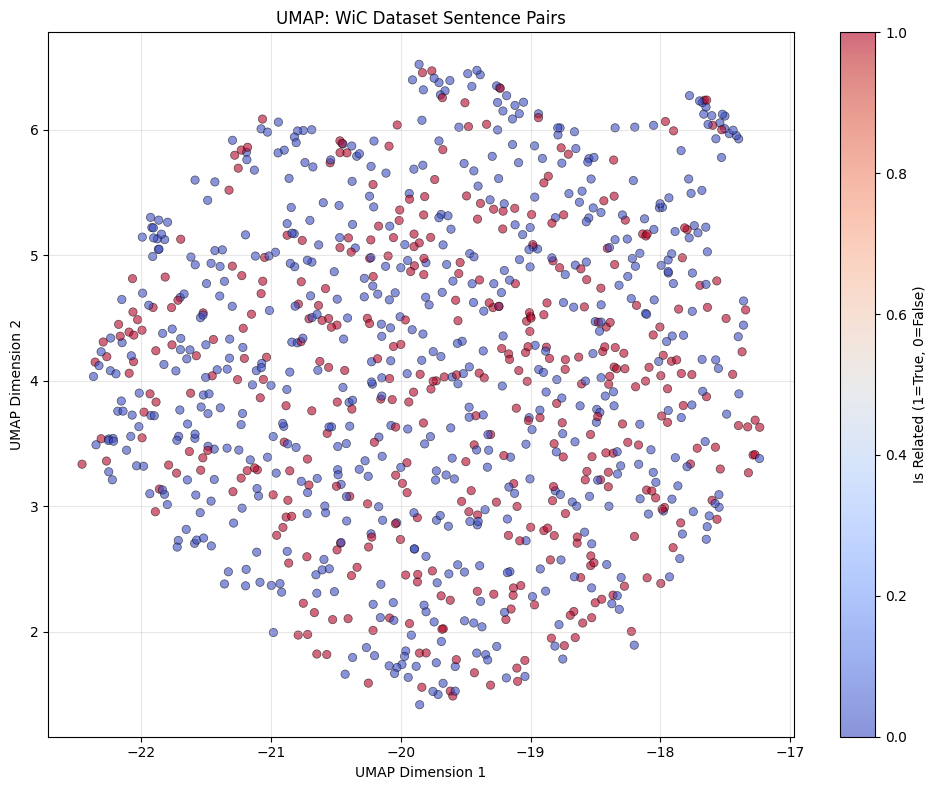

In [19]:
# Visualize UMAP results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
plt.colorbar(scatter, label='Is Related (1=True, 0=False)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP: WiC Dataset Sentence Pairs')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Comparison of All Methods

Let's compare all dimensionality reduction techniques side-by-side to understand their strengths and weaknesses for the WiC dataset.

C:\Users\igeek\AppData\Local\Temp\ipykernel_18696\3156763032.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


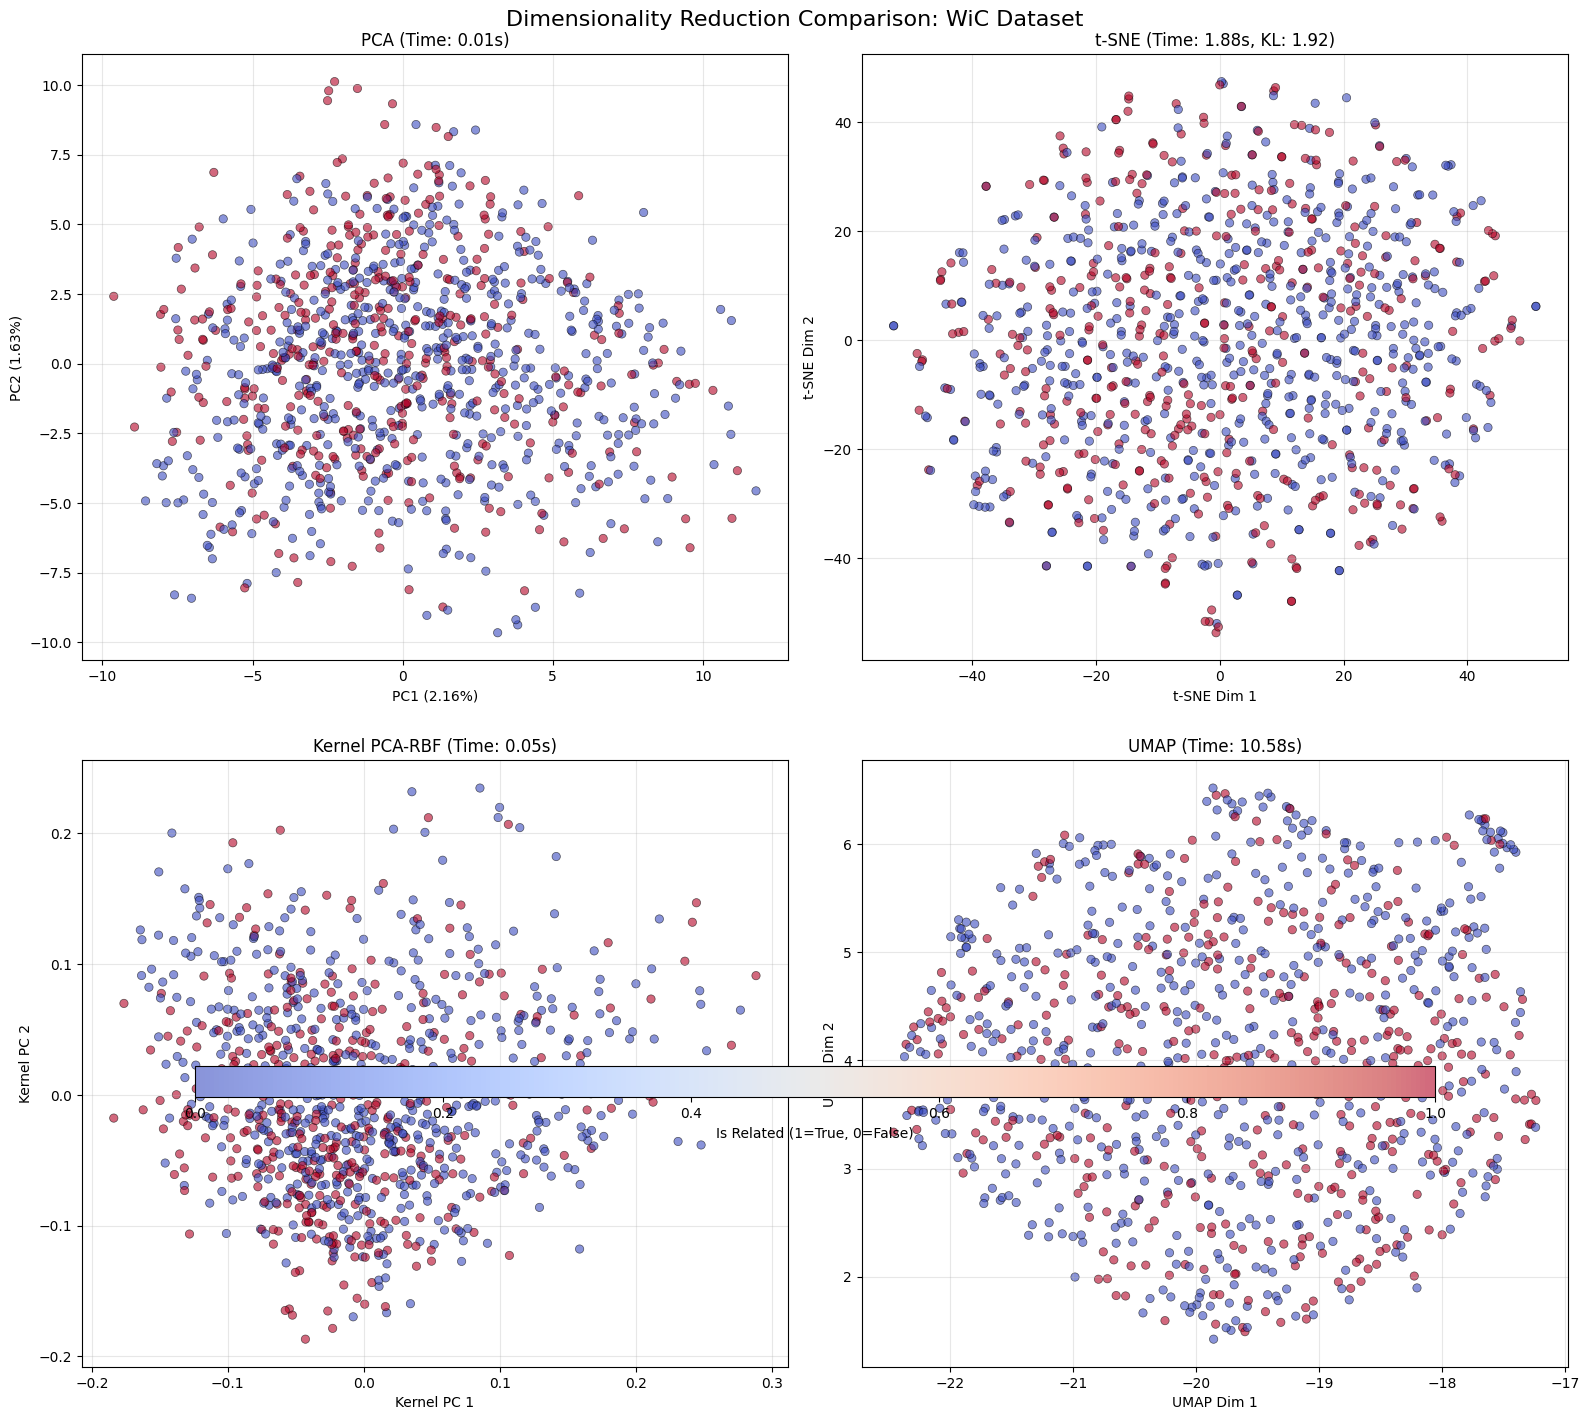

In [20]:
# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# PCA
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0, 0].set_title(f'PCA (Time: {pca_time:.2f}s)')
axes[0, 0].grid(True, alpha=0.3)

# t-SNE
scatter2 = axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0, 1].set_xlabel('t-SNE Dim 1')
axes[0, 1].set_ylabel('t-SNE Dim 2')
axes[0, 1].set_title(f't-SNE (Time: {tsne_time:.2f}s, KL: {tsne.kl_divergence_:.2f})')
axes[0, 1].grid(True, alpha=0.3)

# Kernel PCA (RBF)
scatter3 = axes[1, 0].scatter(X_kpca_rbf[:, 0], X_kpca_rbf[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1, 0].set_xlabel('Kernel PC 1')
axes[1, 0].set_ylabel('Kernel PC 2')
axes[1, 0].set_title(f'Kernel PCA-RBF (Time: {kpca_rbf_time:.2f}s)')
axes[1, 0].grid(True, alpha=0.3)

# UMAP
scatter4 = axes[1, 1].scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1, 1].set_xlabel('UMAP Dim 1')
axes[1, 1].set_ylabel('UMAP Dim 2')
axes[1, 1].set_title(f'UMAP (Time: {umap_time:.2f}s)')
axes[1, 1].grid(True, alpha=0.3)

# Add shared colorbar
fig.colorbar(scatter4, ax=axes, label='Is Related (1=True, 0=False)', 
             orientation='horizontal', pad=0.05, aspect=40)

plt.suptitle('Dimensionality Reduction Comparison: WiC Dataset', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

### Performance Summary

In [21]:
# Create performance comparison table
performance_data = {
    'Method': ['PCA', 't-SNE', 'Kernel PCA (RBF)', 'Kernel PCA (Poly)', 'UMAP'],
    'Computation Time (s)': [pca_time, tsne_time, kpca_rbf_time, kpca_poly_time, umap_time],
    'Type': ['Linear', 'Non-linear', 'Non-linear', 'Non-linear', 'Non-linear'],
    'Preserves': ['Global structure', 'Local structure', 'Non-linear patterns', 'Non-linear patterns', 'Both local & global']
}

perf_df = pd.DataFrame(performance_data)
perf_df = perf_df.sort_values('Computation Time (s)')

print("Performance Comparison:")
print("=" * 80)
print(perf_df.to_string(index=False))
print("=" * 80)

Performance Comparison:
           Method  Computation Time (s)       Type           Preserves
              PCA              0.013420     Linear    Global structure
Kernel PCA (Poly)              0.025880 Non-linear Non-linear patterns
 Kernel PCA (RBF)              0.046638 Non-linear Non-linear patterns
            t-SNE              1.879938 Non-linear     Local structure
             UMAP             10.577663 Non-linear Both local & global


### Quantitative Evaluation: Cluster Separation

Let's evaluate how well each method separates the related vs unrelated pairs using silhouette score.

In [22]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate clustering metrics for each method
methods = {
    'PCA': X_pca,
    't-SNE': X_tsne,
    'Kernel PCA (RBF)': X_kpca_rbf,
    'Kernel PCA (Poly)': X_kpca_poly,
    'UMAP': X_umap
}

metrics_data = []
for method_name, embeddings in methods.items():
    silhouette = silhouette_score(embeddings, y)
    davies_bouldin = davies_bouldin_score(embeddings, y)
    calinski_harabasz = calinski_harabasz_score(embeddings, y)
    
    metrics_data.append({
        'Method': method_name,
        'Silhouette Score': silhouette,
        'Davies-Bouldin Index': davies_bouldin,
        'Calinski-Harabasz Score': calinski_harabasz
    })

metrics_df = pd.DataFrame(metrics_data)
print("\nClustering Quality Metrics:")
print("=" * 90)
print("Silhouette Score: Higher is better (range: -1 to 1)")
print("Davies-Bouldin Index: Lower is better (range: 0 to infinity)")
print("Calinski-Harabasz Score: Higher is better (range: 0 to infinity)")
print("=" * 90)
print(metrics_df.to_string(index=False))
print("=" * 90)


Clustering Quality Metrics:
Silhouette Score: Higher is better (range: -1 to 1)
Davies-Bouldin Index: Lower is better (range: 0 to infinity)
Calinski-Harabasz Score: Higher is better (range: 0 to infinity)
           Method  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
              PCA          0.007599              8.368274                11.003641
            t-SNE          0.011829             20.816238                 1.914129
 Kernel PCA (RBF)          0.003871              8.120359                11.335447
Kernel PCA (Poly)          0.009444              8.170627                11.503308
             UMAP          0.001851             10.366053                 7.671525


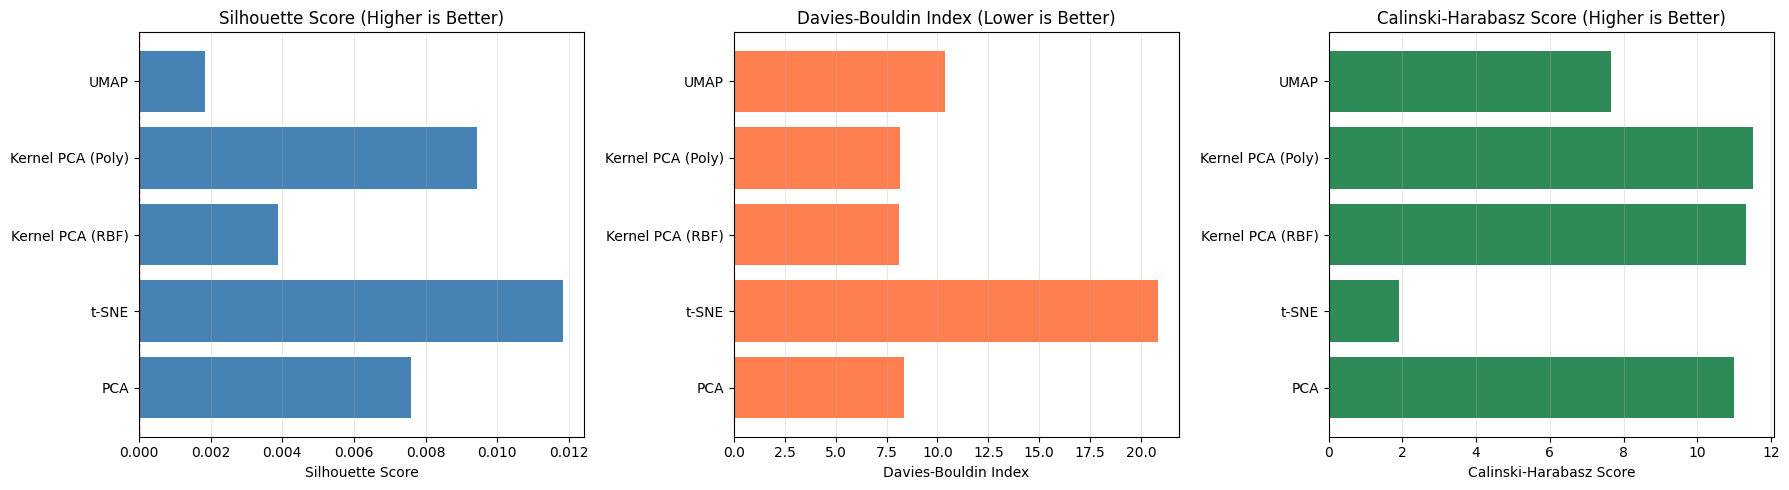

In [23]:
# Visualize clustering metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score
axes[0].barh(metrics_df['Method'], metrics_df['Silhouette Score'], color='steelblue')
axes[0].set_xlabel('Silhouette Score')
axes[0].set_title('Silhouette Score (Higher is Better)')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# Davies-Bouldin Index (invert for visualization - lower is better)
axes[1].barh(metrics_df['Method'], metrics_df['Davies-Bouldin Index'], color='coral')
axes[1].set_xlabel('Davies-Bouldin Index')
axes[1].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1].grid(True, alpha=0.3, axis='x')

# Calinski-Harabasz Score
axes[2].barh(metrics_df['Method'], metrics_df['Calinski-Harabasz Score'], color='seagreen')
axes[2].set_xlabel('Calinski-Harabasz Score')
axes[2].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Additional Analysis: Variance Explained (PCA)

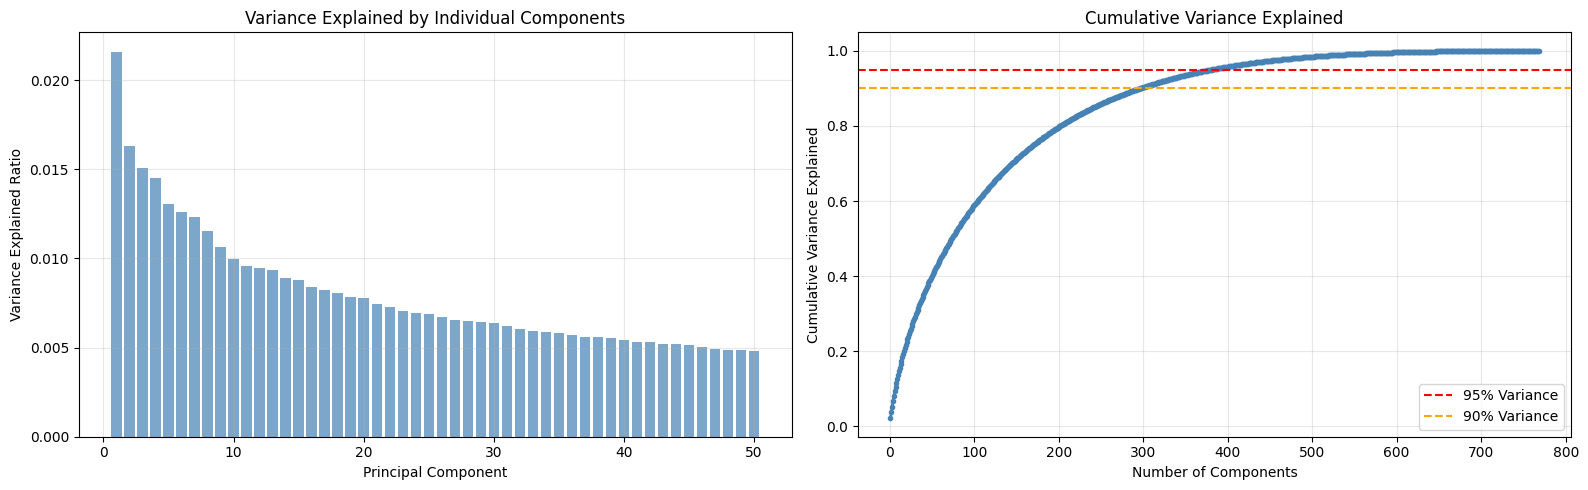

Components needed for 90% variance: 297
Components needed for 95% variance: 382
Components needed for 99% variance: 541


In [26]:
# Analyze variance explained by different numbers of components
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot variance explained
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual variance
axes[0].bar(range(1, min(51, len(pca_full.explained_variance_ratio_) + 1)), 
            pca_full.explained_variance_ratio_[:50], 
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained Ratio')
axes[0].set_title('Variance Explained by Individual Components')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
             marker='o', markersize=3, linewidth=2, color='steelblue')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for different variance thresholds
for threshold in [0.90, 0.95, 0.99]:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")